In [429]:
import networkx as nx
import random
import math

In [430]:
G = nx.Graph()

In [450]:
G.add_node(1,contracted=False)
G.add_node(2,contracted=False)
G.add_node(3,contracted=False)
G.add_node(4,contracted=False)
G.add_node(5,contracted=False)
G.add_node(6,contracted=False)
G.add_node(7,contracted=False)
G.add_node(8,contracted=False)
G.add_node(9,contracted=False)
G.add_node(10,contracted=False)
G.add_node(11,contracted=False)
G.add_node(12,contracted=False)
G.add_node(13,contracted=False)
G.add_node(14,contracted=False)

In [451]:
edges = [
    (1,2,{'weight':10}),
    (1,3,{'weight':4}),
    (1,7,{'weight':7}),
    (2,3,{'weight':5}),
    (2,4,{'weight':2}),
    (3,4,{'weight':2}),
    (3,6,{'weight':1}),
    (4,5,{'weight':5}),
    (5,10,{'weight':7}),
    (6,7,{'weight':4}),
    (6,5,{'weight':3}),
    (6,9,{'weight':1}),
    (7,8,{'weight':6}),
    (8,9,{'weight':3}),
    (8,13,{'weight':5}),
    (9,12,{'weight':1}),
    (9,10,{'weight':3}),
    (10,11,{'weight':4}),
    (11,12,{'weight':3}),
    (11,13,{'weight':4}),
    (12,13,{'weight':2})
]

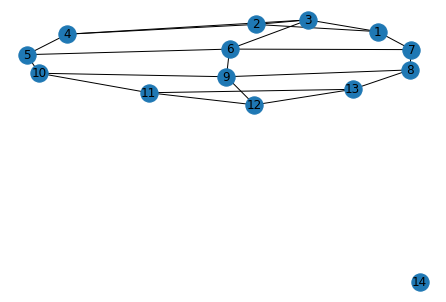

In [452]:
G.add_edges_from([*edges])
nx.draw(G,with_labels=True)

In [453]:
def dijkstra_with_contraction(G, source, destination, contracted = None):
    if contracted:
        nx.set_node_attributes(G, {contracted: True}, 'contracted')
        
    shortest_path = dict()
    heap = list()
    
    for i in G.nodes():
        if not nx.get_node_attributes(G, 'contracted')[i]:
            shortest_path[i] = math.inf
            heap.append(i)
    shortest_path[source] = 0
    
    while len(heap) > 0:
        q = min(heap, key = lambda node : shortest_path[node])
        if q == destination: return shortest_path[q]
        heap.remove(q)
        for v in G[q]:
            if not nx.get_node_attributes(G, 'contracted')[v]:
                distance = shortest_path[q] + G[q][v]['weight']
                if distance < shortest_path[v]:
                    shortest_path[v] = distance
    if contracted:
        nx.set_node_attributes(G, {contracted: False}, 'contracted')
    return math.inf

In [454]:
shortest_paths = dict()

In [458]:
%time
for i in G.nodes():
    shortest_paths[i] = dict()
    for v in G.nodes():
        shortest_paths[i][v] = dijkstra_with_contraction(G, i, v,contracted=1)

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 18.4 µs


In [459]:
shortest_paths

{1: {1: inf,
  2: inf,
  3: inf,
  4: inf,
  5: inf,
  6: inf,
  7: inf,
  8: inf,
  9: inf,
  10: inf,
  11: inf,
  12: inf,
  13: inf,
  14: inf},
 2: {1: inf,
  2: 0,
  3: 4,
  4: 2,
  5: inf,
  6: 5,
  7: 9,
  8: 9,
  9: 6,
  10: 9,
  11: 10,
  12: 7,
  13: 9,
  14: inf},
 3: {1: inf,
  2: 4,
  3: 0,
  4: 2,
  5: inf,
  6: 1,
  7: 5,
  8: 5,
  9: 2,
  10: 5,
  11: 6,
  12: 3,
  13: 5,
  14: inf},
 4: {1: inf,
  2: 2,
  3: 2,
  4: 0,
  5: inf,
  6: 3,
  7: 7,
  8: 7,
  9: 4,
  10: 7,
  11: 8,
  12: 5,
  13: 7,
  14: inf},
 5: {1: inf,
  2: inf,
  3: inf,
  4: inf,
  5: inf,
  6: inf,
  7: inf,
  8: inf,
  9: inf,
  10: inf,
  11: inf,
  12: inf,
  13: inf,
  14: inf},
 6: {1: inf,
  2: 5,
  3: 1,
  4: 3,
  5: inf,
  6: 0,
  7: 4,
  8: 4,
  9: 1,
  10: 4,
  11: 5,
  12: 2,
  13: 4,
  14: inf},
 7: {1: inf,
  2: 9,
  3: 5,
  4: 7,
  5: inf,
  6: 4,
  7: 0,
  8: 6,
  9: 5,
  10: 8,
  11: 9,
  12: 6,
  13: 8,
  14: inf},
 8: {1: inf,
  2: 9,
  3: 5,
  4: 7,
  5: inf,
  6: 4,
  7: 6,
  8

In [427]:
edge_difference = []

In [428]:
for i in G.nodes():
    edges_incident = len(G[i])
    
    contracted_node_paths = shortest_paths[i]
    del shortest_paths[i]
    
    new_graph = [*G.nodes()]
    new_graph.remove(i)
    
    new_shortest_paths = dict()
    
    for source in new_graph:
        new_shortest_paths[source] = dict()
        for destination in new_graph:
            new_shortest_paths[source][destination] = dijkstra_with_contraction(G, source, destination, contracted = i)
    print(i)
    print(new_shortest_paths)
    print("..............")
            
    shortest_paths[i] = contracted_node_paths

1
{2: {2: 0, 3: 4, 4: 2, 5: 7, 6: 5, 7: 9, 8: 9, 9: 6, 10: 9, 11: 10, 12: 7, 13: 9, 14: inf}, 3: {2: 4, 3: 0, 4: 2, 5: 4, 6: 1, 7: 5, 8: 5, 9: 2, 10: 5, 11: 6, 12: 3, 13: 5, 14: inf}, 4: {2: 2, 3: 2, 4: 0, 5: 5, 6: 3, 7: 7, 8: 7, 9: 4, 10: 7, 11: 8, 12: 5, 13: 7, 14: inf}, 5: {2: 7, 3: 4, 4: 5, 5: 0, 6: 3, 7: 7, 8: 7, 9: 4, 10: 7, 11: 8, 12: 5, 13: 7, 14: inf}, 6: {2: 5, 3: 1, 4: 3, 5: 3, 6: 0, 7: 4, 8: 4, 9: 1, 10: 4, 11: 5, 12: 2, 13: 4, 14: inf}, 7: {2: 9, 3: 5, 4: 7, 5: 7, 6: 4, 7: 0, 8: 6, 9: 5, 10: 8, 11: 9, 12: 6, 13: 8, 14: inf}, 8: {2: 9, 3: 5, 4: 7, 5: 7, 6: 4, 7: 6, 8: 0, 9: 3, 10: 6, 11: 7, 12: 4, 13: 5, 14: inf}, 9: {2: 6, 3: 2, 4: 4, 5: 4, 6: 1, 7: 5, 8: 3, 9: 0, 10: 3, 11: 4, 12: 1, 13: 3, 14: inf}, 10: {2: 9, 3: 5, 4: 7, 5: 7, 6: 4, 7: 8, 8: 6, 9: 3, 10: 0, 11: 4, 12: 4, 13: 6, 14: inf}, 11: {2: 10, 3: 6, 4: 8, 5: 8, 6: 5, 7: 9, 8: 7, 9: 4, 10: 4, 11: 0, 12: 3, 13: 4, 14: inf}, 12: {2: 7, 3: 3, 4: 5, 5: 5, 6: 2, 7: 6, 8: 4, 9: 1, 10: 4, 11: 3, 12: 0, 13: 2, 14: inf}, 13

8
{1: {1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: inf, 10: inf, 11: inf, 12: inf, 13: inf, 14: inf}, 2: {1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: inf, 10: inf, 11: inf, 12: inf, 13: inf, 14: inf}, 3: {1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: inf, 10: inf, 11: inf, 12: inf, 13: inf, 14: inf}, 4: {1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: inf, 10: inf, 11: inf, 12: inf, 13: inf, 14: inf}, 5: {1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: inf, 10: inf, 11: inf, 12: inf, 13: inf, 14: inf}, 6: {1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: inf, 10: inf, 11: inf, 12: inf, 13: inf, 14: inf}, 7: {1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: inf, 10: inf, 11: inf, 12: inf, 13: inf, 14: inf}, 9: {1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: 0, 10: 3, 11: 4, 12: 1, 13: 3, 14: inf}, 10: {1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: 3, 10: 0, 11: 4, 12: 4, 13: 6, 

In [302]:
shortest_paths

{1: {1: 0,
  2: 8,
  3: 4,
  4: 6,
  5: 8,
  6: 5,
  7: 7,
  8: 9,
  9: 6,
  10: 9,
  11: 10,
  12: 7,
  13: 9,
  14: inf},
 2: {1: 8,
  2: 0,
  3: 4,
  4: 2,
  5: 7,
  6: 5,
  7: 9,
  8: 9,
  9: 6,
  10: 9,
  11: 10,
  12: 7,
  13: 9,
  14: inf},
 3: {1: 4,
  2: 4,
  3: 0,
  4: 2,
  5: 4,
  6: 1,
  7: 5,
  8: 5,
  9: 2,
  10: 5,
  11: 6,
  12: 3,
  13: 5,
  14: inf},
 4: {1: 6,
  2: 2,
  3: 2,
  4: 0,
  5: 5,
  6: 3,
  7: 7,
  8: 7,
  9: 4,
  10: 7,
  11: 8,
  12: 5,
  13: 7,
  14: inf},
 5: {1: 8,
  2: 7,
  3: 4,
  4: 5,
  5: 0,
  6: 3,
  7: 7,
  8: 7,
  9: 4,
  10: 7,
  11: 8,
  12: 5,
  13: 7,
  14: inf},
 6: {1: 5,
  2: 5,
  3: 1,
  4: 3,
  5: 3,
  6: 0,
  7: 4,
  8: 4,
  9: 1,
  10: 4,
  11: 5,
  12: 2,
  13: 4,
  14: inf},
 7: {1: 7,
  2: 9,
  3: 5,
  4: 7,
  5: 7,
  6: 4,
  7: 0,
  8: 6,
  9: 5,
  10: 8,
  11: 9,
  12: 6,
  13: 8,
  14: inf},
 8: {1: 9,
  2: 9,
  3: 5,
  4: 7,
  5: 7,
  6: 4,
  7: 6,
  8: 0,
  9: 3,
  10: 6,
  11: 7,
  12: 4,
  13: 5,
  14: inf},
 9: {1: 6,
  2

In [310]:
v = [*G.nodes()]

In [311]:
v.remove(1)

In [312]:
v

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]